<a href="https://colab.research.google.com/github/Swarno-Coder/GradCAM-PyTorch/blob/master/Deep_Learning_with_PyTorch_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM - Gradient Class Activation Map

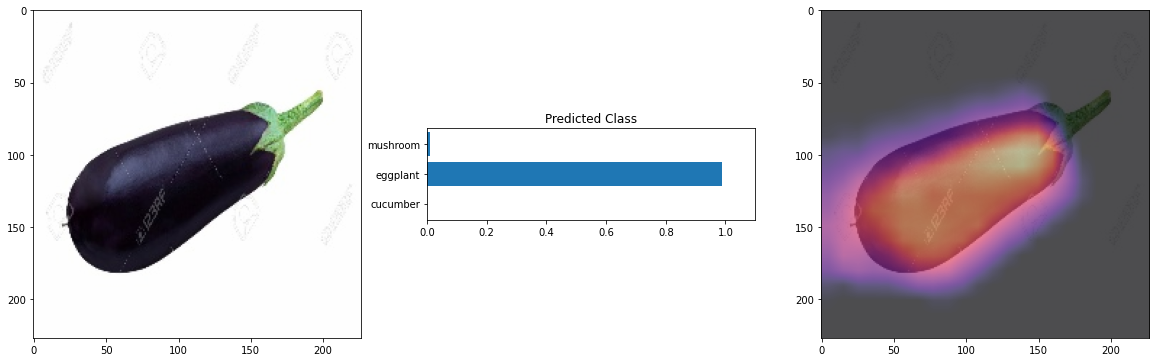

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 14.32 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-l5w7yli4
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-l5w7yli4
  Resolved https://github.com/albumentations-team/albumentations to commit 3c510e1422f6663ccd5026950af2d9ea85b5302a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


# Imports

In [2]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
BASE_PATH = '/content/GradCAM-Dataset/'

LR = 0.001
EPOCHS = 20
DEVICE = 'cuda'
BAT_SIZE = 16

In [5]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [6]:
traindf, validdf = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [7]:
trainaug = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
validaug = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Image Dataset

In [8]:
class ImageDataset(Dataset):

    def __init__(self, df, data_dir = None, augs = None,):
        self.df = df
        self.augs = augs
        self.data_dir = data_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        img_path = self.data_dir + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label = row.label

        if self.augs:
            data = self.augs(image = img)
            img = data['image']

        img = torch.from_numpy(img).permute(2, 0, 1)

        return img, label

In [9]:
trainset = ImageDataset(traindf, BASE_PATH,trainaug)
validset = ImageDataset(validdf, BASE_PATH,validaug)

In [10]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


Text(0.5, 1.0, '1')

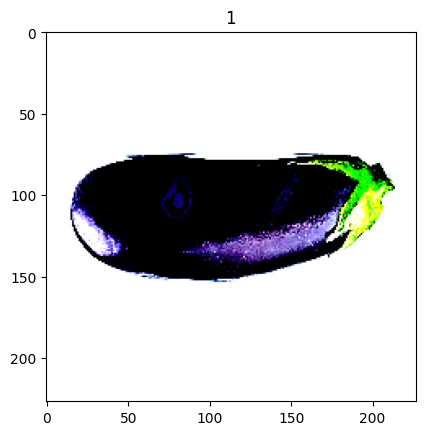

In [11]:
img, label = trainset[0]

plt.imshow(img.permute(1, 2, 0))
plt.title(label)

# Load Dataset into Batches

In [12]:
trainloader = DataLoader(trainset, BAT_SIZE, shuffle=True)
validloader = DataLoader(validset, BAT_SIZE)

In [13]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [14]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

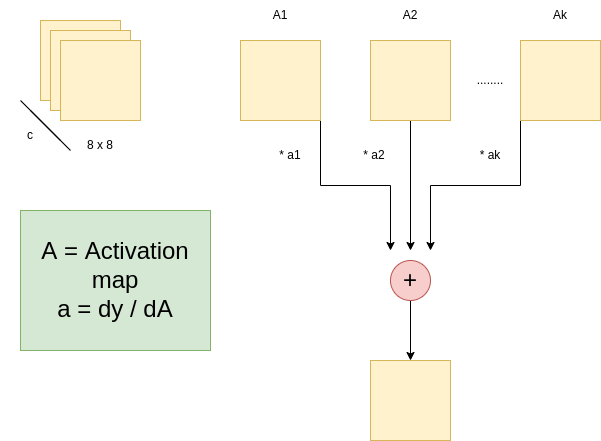

In [15]:
from torch.nn.modules.pooling import MaxPool2d

class ImageModel(nn.Module):
  def __init__(self) -> None:
     super(ImageModel, self).__init__()

     self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((4, 4), 2),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((4, 4), 2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((4, 4), 2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
        nn.ReLU()
     )

     self.maxpool = nn.MaxPool2d((4, 4), 2)
     self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3)
     )
     self.gradient = None

  def activation_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images)

    h = x.register_hook(self.activation_hook)
    x = self.maxpool(x)
    x = self.classifier(x)

    return x
  def get_activation_gradients(self):
    return self.gradient

  def get_activation(self, x):
    return self.feature_extractor(x)

In [16]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [17]:
def train_fn(model, dataloader, optim, criter):
  total_loss = 0.0
  model.train()
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optim.zero_grad()
    logits = model(images)
    loss = criter(logits, labels)
    loss.backward()
    optim.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [18]:
def eval_fn(model, dataloader, criter):
  total_loss = 0.0
  model.eval()
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(images)
    loss = criter(logits, labels)

    total_loss += loss.item()

  return total_loss / len(dataloader)

# Training Loop

In [19]:
optim = torch.optim.Adam(model.parameters(), lr=LR)
criter = torch.nn.CrossEntropyLoss()

In [20]:
best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optim, criter)
  valid_loss = eval_fn(model, validloader, criter)

  if valid_loss < best_val_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_val_loss = valid_loss
    print('SAVED')

  print(f'EPOCH: {i+1} Train loss: {train_loss} Valid_loss: {valid_loss}')

100%|██████████| 3/3 [00:00<00:00, 32.35it/s]


SAVED
EPOCH: 1 Train loss: 1.227426964044571 Valid_loss: 1.1396400928497314


100%|██████████| 3/3 [00:00<00:00, 34.30it/s]


SAVED
EPOCH: 2 Train loss: 0.9195570886135102 Valid_loss: 0.6946590542793274


100%|██████████| 3/3 [00:00<00:00, 35.54it/s]


EPOCH: 3 Train loss: 0.7187515586614609 Valid_loss: 0.8933291832605997


100%|██████████| 3/3 [00:00<00:00, 38.48it/s]


SAVED
EPOCH: 4 Train loss: 0.6620466589927674 Valid_loss: 0.5477816959222158


100%|██████████| 3/3 [00:00<00:00, 24.17it/s]


EPOCH: 5 Train loss: 0.45447016060352324 Valid_loss: 0.6629128853480021


100%|██████████| 3/3 [00:00<00:00, 38.18it/s]


EPOCH: 6 Train loss: 0.43550985436886547 Valid_loss: 0.5519410818815231


100%|██████████| 3/3 [00:00<00:00, 38.91it/s]


SAVED
EPOCH: 7 Train loss: 0.3550073280930519 Valid_loss: 0.407810111840566


100%|██████████| 3/3 [00:00<00:00, 38.33it/s]


SAVED
EPOCH: 8 Train loss: 0.2712357357144356 Valid_loss: 0.25244419773419696


100%|██████████| 3/3 [00:00<00:00, 36.46it/s]


SAVED
EPOCH: 9 Train loss: 0.4060093693435192 Valid_loss: 0.19542841737469038


100%|██████████| 3/3 [00:00<00:00, 26.20it/s]


EPOCH: 10 Train loss: 0.34380741491913797 Valid_loss: 0.5077070196469625


100%|██████████| 3/3 [00:00<00:00, 15.35it/s]


EPOCH: 11 Train loss: 0.2521904081106186 Valid_loss: 0.4045669039090474


100%|██████████| 3/3 [00:00<00:00, 18.47it/s]


EPOCH: 12 Train loss: 0.1805946134030819 Valid_loss: 0.4189295054723819


100%|██████████| 3/3 [00:00<00:00,  7.67it/s]


EPOCH: 13 Train loss: 0.28937084078788755 Valid_loss: 0.36962855358918506


100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


EPOCH: 14 Train loss: 0.21175842322409152 Valid_loss: 0.5165398816267649


100%|██████████| 3/3 [00:00<00:00, 12.11it/s]


EPOCH: 15 Train loss: 0.17274011792615057 Valid_loss: 0.20770536611477533


100%|██████████| 3/3 [00:00<00:00, 20.43it/s]


SAVED
EPOCH: 16 Train loss: 0.15512253334745765 Valid_loss: 0.16546837985515594


100%|██████████| 3/3 [00:00<00:00, 14.37it/s]


EPOCH: 17 Train loss: 0.0888685129582882 Valid_loss: 0.19589811315139136


100%|██████████| 3/3 [00:00<00:00, 20.74it/s]


EPOCH: 18 Train loss: 0.08907911647111177 Valid_loss: 0.2571122804656625


100%|██████████| 3/3 [00:00<00:00, 20.25it/s]


EPOCH: 19 Train loss: 0.11815747492946685 Valid_loss: 0.6150055428345998


100%|██████████| 3/3 [00:00<00:00, 37.04it/s]

EPOCH: 20 Train loss: 0.13344405232928694 Valid_loss: 0.22052388483037552


# Get GradCAM

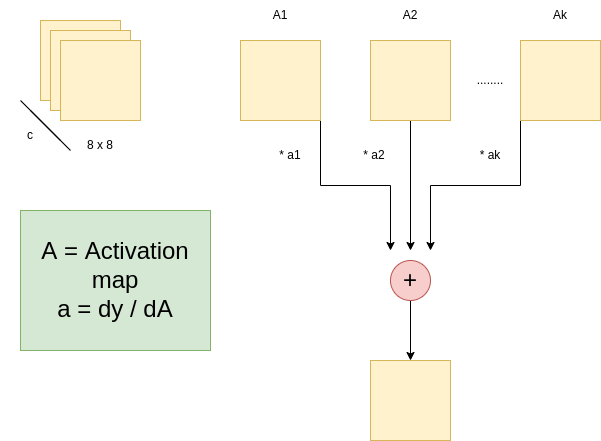

In [21]:
def get_gradcam(model, image, label, size):

  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim = [0, 2, 3])
  activations = model.get_activation(image).detach()

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap

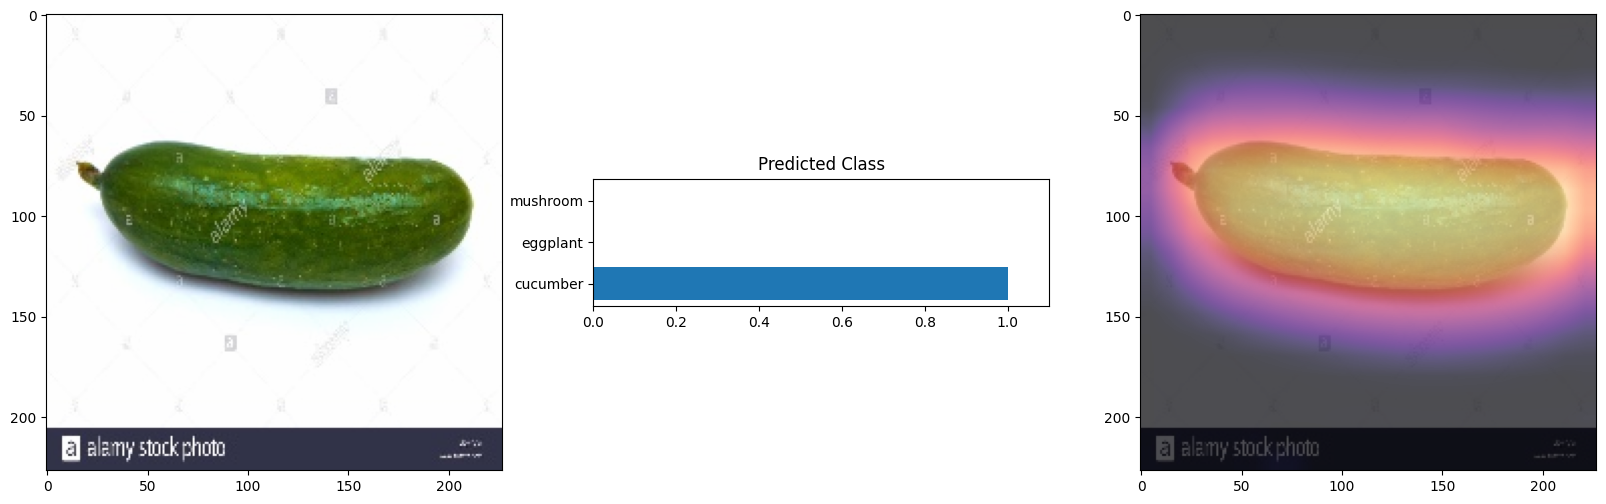

In [31]:
img, label = validset[8]

denorm_image = img.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
img = img.unsqueeze(0).to(DEVICE)

pred = model(img)

heatmap = get_gradcam(model, img, pred[0][0], size=227)
utils.plot_heatmap(denorm_image, pred, heatmap)